<a href="https://colab.research.google.com/github/seyeonJeong/average_temperature_forecast_model/blob/main/weather_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd

# 서울의 2010년 2월 ~ 2024년 3월 19일까지의 기온 데이터이다.
df = pd.read_csv('./weather_data/weather_seoul.csv', encoding='cp949')

# 날짜 데이터를 나눠준다. (원본에는 2023-03-01 이런식으로 되어있다.)
df['날짜'] = pd.to_datetime(df['날짜'])
df['yyyy'] = df['날짜'].dt.strftime('%Y')
df['mm'] = df['날짜'].dt.strftime('%m')
df['dd'] = df['날짜'].dt.strftime('%d')

# 날짜 데이터를 삭제
df = df.drop('날짜', axis=1)

# 새로운 열의 타입을 변경해줌
df['yyyy'] = df['yyyy'].astype('float64')
df['mm'] = df['mm'].astype('float64')
df['dd'] = df['dd'].astype('float64')

# float로 잘 변환되었다.
df.dtypes

,날짜,평균기온(℃),최저기온(℃),최고기온(℃)
0,2010-02-01,0.8,-2.6,5.1
1,2010-02-02,-6.2,-9.1,-2.6
2,2010-02-03,-8.0,-10.8,-5.0
3,2010-02-04,-4.3,-8.3,-0.6
4,2010-02-05,-5.5,-7.9,-1.9
...,...,...,...,...
5156,2024-03-15,8.9,4.0,14.5
5157,2024-03-16,10.9,4.4,18.3
5158,2024-03-17,8.8,5.4,12.2
5159,2024-03-18,7.1,1.4,13.2


In [5]:
# 상관관계를 확인 최저기온 최고기온은 당연히 평균과 관련있다.
# 최저, 최고 기온을 제외하면 'mm' 열이 가장 상관계수가 높다.

df_corr = df.corr()
df_corr_sort = df_corr.sort_values('평균기온(℃)', ascending=False)
df_corr_sort['평균기온(℃)'].head(10)

평균기온(℃)    1.000000
최저기온(℃)    0.989767
최고기온(℃)    0.989332
mm         0.240473
dd         0.004790
yyyy       0.001743
Name: 평균기온(℃), dtype: float64

In [6]:
from sklearn.model_selection import train_test_split
# 연도, 월, 일을 학습시킨다.
cols_train = ['yyyy','mm','dd']
x_train_pre = df[cols_train]
# 정답 데이터는 평균기온의 값들이다.
y = df['평균기온(℃)'].values
# train, test 8:2비율로 나눠준다.
x_train, x_test, y_train, y_test = train_test_split(x_train_pre, y, test_size=0.2)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 모델을 만들어준다. 활성화함수는 relu를 사용함
# 출력층은 예측 값이 그대로 나와야하므로 따로 활성화함수를 두지 않았다.
# 분류 모델 이라면 sigmoid, softmax(다중 분류)를 사용하면 좋다.
# FC층의 노드 개수를 40 20 1로 했을때 loss가 110 정도에서 끝나버린다. 그래서 노드 개수와 층 개수를 늘렸다.
model = Sequential()
model.add(Dense(128, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(48, activation='relu'))
model.add(Dense(1))
model.summary()

# optimizer은 adam을 사용 손실함수는 MSE를 사용하였다.
model.compile(optimizer='adam', loss='mean_squared_error')

# 오차가 어느 횟수 동안 낮아지지 않으면 학습을 종료시키는 기능이다.
# 여기서는 50회로 지정하였고 그 기준은 validation loss값이다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=50)

# 모델을 저장하는 경로
modelpath = "./weather_data/model/1_seoul.hdf5"
# 모델을 저장 가장 best 모델만 저장한다.
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)
# 학습을 실행 validation은 0.25의 비율로 정하였다. 이는 train set에서 25%로 8:2에서 6:2:2가 된다.
# epoch는 2000으로 정했지만 earlystopping을 사용하였으므로 이 환경에서는 2000까지 도달하지는 않았다.
history = model.fit(x_train, y_train, validation_split=0.25, epochs=2000, batch_size=32, callbacks=[early_stopping_callback, checkpointer])


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 128)               512       
                                                                 
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 dense_32 (Dense)            (None, 48)                3120      
                                                                 
 dense_33 (Dense)            (None, 1)                 49        
                                                                 
Total params: 11937 (46.63 KB)
Trainable params: 11937 (46.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2000
97/97 [==============================] - 1s 5ms/step - loss: 524.1747 - val_loss: 118.5968
Epoch 2/2000
66/97 [===================>......

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


97/97 [==============================] - 0s 3ms/step - loss: 121.0451 - val_loss: 124.3429
Epoch 3/2000
97/97 [==============================] - 0s 3ms/step - loss: 121.4928 - val_loss: 119.8889
Epoch 4/2000
97/97 [==============================] - 0s 3ms/step - loss: 125.4995 - val_loss: 120.0115
Epoch 5/2000
97/97 [==============================] - 0s 3ms/step - loss: 121.7697 - val_loss: 116.7885
Epoch 6/2000
97/97 [==============================] - 0s 3ms/step - loss: 119.3510 - val_loss: 119.2330
Epoch 7/2000
97/97 [==============================] - 0s 3ms/step - loss: 129.3472 - val_loss: 220.4477
Epoch 8/2000
97/97 [==============================] - 0s 3ms/step - loss: 125.2597 - val_loss: 135.0372
Epoch 9/2000
97/97 [==============================] - 0s 3ms/step - loss: 125.3977 - val_loss: 117.0262
Epoch 10/2000
97/97 [==============================] - 0s 3ms/step - loss: 124.0571 - val_loss: 128.3546
Epoch 11/2000
97/97 [==============================] - 0s 3ms/step - loss: 1

In [28]:
# 실제 온도와 예상 온도를 출력한다.
# 확인해보면 많이 차이가 나도 5도 정도의 차이가 남을 알 수 있다.
# 아마 모델이 강건하지 않아서 발생하는 현상이겠지만, 실제 세계에서도 +-5도 정도의 차이가 날 수 있다고 생각했다.

real_temp = []
pred_temp = []

x_num = []

n_iter=0

y_prediction = model.predict(x_test).flatten()

for i in range(50):
    real = y_test[i]
    prediction = y_prediction[i]
    print("실제온도: {:.2f}, 예상온도: {:.2f}".format(real, prediction))
    real_temp.append(real)
    pred_temp.append(prediction)
    n_iter += 1
    x_num.append(n_iter)

33/33 [==============================] - 0s 2ms/step
실제온도: -3.70, 예상온도: -1.68
실제온도: 2.20, 예상온도: -1.67
실제온도: 17.50, 예상온도: 16.51
실제온도: 22.20, 예상온도: 24.38
실제온도: 14.80, 예상온도: 12.56
실제온도: 1.50, 예상온도: 6.28
실제온도: 1.40, 예상온도: 3.30
실제온도: 27.70, 예상온도: 26.07
실제온도: 21.20, 예상온도: 22.47
실제온도: 6.90, 예상온도: 5.71
실제온도: 11.40, 예상온도: 10.40
실제온도: 29.30, 예상온도: 27.36
실제온도: 24.70, 예상온도: 27.43
실제온도: 1.10, 예상온도: 5.33
실제온도: 23.10, 예상온도: 23.79
실제온도: 17.50, 예상온도: 17.34
실제온도: 29.00, 예상온도: 27.16
실제온도: 8.10, 예상온도: -1.04
실제온도: 3.50, 예상온도: -1.02
실제온도: 2.50, 예상온도: 0.71
실제온도: 9.40, 예상온도: 16.30
실제온도: 14.50, 예상온도: 18.11
실제온도: 5.90, 예상온도: -1.67
실제온도: 21.00, 예상온도: 25.53
실제온도: 24.80, 예상온도: 20.90
실제온도: 0.50, 예상온도: -0.21
실제온도: 4.70, 예상온도: -1.68
실제온도: 9.40, 예상온도: 10.76
실제온도: 19.20, 예상온도: 21.60
실제온도: 3.50, 예상온도: -1.69
실제온도: 2.70, 예상온도: -0.80
실제온도: 19.30, 예상온도: 19.27
실제온도: 25.40, 예상온도: 27.01
실제온도: 9.50, 예상온도: 1.48
실제온도: 2.30, 예상온도: -1.68
실제온도: 33.70, 예상온도: 26.96
실제온도: 20.40, 예상온도: 12.53
실제온도: 10.20, 예상온도: 8.69
실제온도: 4.90, 예상온도: -0.

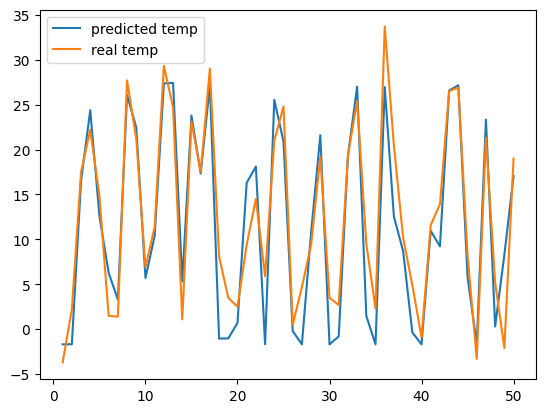

In [32]:
import matplotlib.pyplot as plt

# 그래프를 통해 실제 온도와 예측 온도가 얼마나 흡사한지 보여준다.
# 결과를 보면 거의 비슷한 동향을 따라가는 것을 볼 수 있다.

plt.plot(x_num, pred_temp, label='predicted temp')
plt.plot(x_num, real_temp, label='real temp')
plt.legend()
plt.show()

In [34]:
import pandas as pd

# 마치 날씨 예측 프로그램처럼 만들어 보았다. 데이터 개수를 입력하고
# 연, 월, 일 (2023 10 21)을 입력하면 new_data에 반영하여 예측값을 출력한다.
# 예시 출력 결과를 보면 10월 초와 10월 말의 온도차가 나는 것으로 보아 day에 대한 변화도 잘 예측한다.
# 또한 월의 변화에 가장 민감한데, 온도와 가장 상관관계가 높기 때문이다. (실제로도 계절의 변화가 온도 변화에 가장 크게 기여)

print("데이터 개수를 입력하시오: ")
n = int(input())

year_list = []
month_list = []
day_list = []

for i in range(n):
    print("연, 월, 일 순으로 입력하시오")
    year,month,day = map(int, input().split())

    year_list.append(year)
    month_list.append(month)
    day_list.append(day)


# 주어진 데이터셋
data = {
    'yyyy': year_list,
    'mm': month_list,
    'dd': day_list
}

# 데이터프레임 생성
new_data = pd.DataFrame(data)

pre = model.predict(new_data).flatten()

for i in range(len(pre)):
    print(str(int(new_data.iloc[i]['yyyy']))
    ,"년", str(int(new_data.iloc[i]['mm']))
    ,"월",str(int(new_data.iloc[i]['dd']))
    ,"일의 예상 평균 온도는 "
    ,str(int(pre[i]))
    ,"도 입니다.")


데이터 개수를 입력하시오: 
5
연, 월, 일 순으로 입력하시오
2023 10 21
연, 월, 일 순으로 입력하시오
2023 10 1
연, 월, 일 순으로 입력하시오
2030 7 6
연, 월, 일 순으로 입력하시오
2019 12 1
연, 월, 일 순으로 입력하시오
2010 5 1
1/1 [==============================] - 0s 22ms/step
2023 년 10 월 21 일의 예상 평균 온도는  15 도 입니다.
2023 년 10 월 1 일의 예상 평균 온도는  20 도 입니다.
2030 년 7 월 6 일의 예상 평균 온도는  24 도 입니다.
2019 년 12 월 1 일의 예상 평균 온도는  5 도 입니다.
2010 년 5 월 1 일의 예상 평균 온도는  14 도 입니다.
